In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import xarray as xr

import sys
sys.path.append('..')
import plot_tools as pt
sys.path.append('../src')
import fourier_for_real as fourier
# pt.set_style('dark')
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# just to disable the HDMF cache namespace warnings, REMOVE to see them
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_directory = os.path.join(os.path.expanduser('~'), 'Downloads', 'ecephys_cache_dir')
manifest_path = os.path.join(data_directory, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
sessions = cache.get_session_table()

## Genotypes used for Phototagging

In [3]:
sessions.full_genotype.value_counts()

wt/wt                                              30
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      12
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     8
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       8
Name: full_genotype, dtype: int64

# 1) Select the Sessions

In [7]:
PV_sessions = sessions[(sessions.full_genotype.str.find('Pvalb-IRES-Cre') > -1) & \
                        #(sessions.session_type == 'brain_observatory_1.1') & \
                        #(sessions.session_type == 'functional_connectivity') & \
                        (['VISp' in acronyms for acronyms in sessions.ecephys_structure_acronyms])]

SST_sessions = sessions[(sessions.full_genotype.str.find('Sst-IRES-Cre') > -1) & \
                        #(sessions.session_type == 'brain_observatory_1.1') & \
                        #(sessions.session_type == 'functional_connectivity') & \
                        (['VISp' in acronyms for acronyms in sessions.ecephys_structure_acronyms])]

In [8]:
PV_sessions = sessions[sessions.full_genotype.str.find('Pvalb-IRES-Cre') > -1]
SST_sessions = sessions[sessions.full_genotype.str.find('Sst-IRES-Cre') > -1]

In [10]:
Visual_Areas = [v for v in np.unique(np.concatenate([np.array(x, dtype=str)\
                                for x in sessions.ecephys_structure_acronyms.values])) if 'VIS' in v]
Visual_Areas

['VIS',
 'VISal',
 'VISam',
 'VISl',
 'VISli',
 'VISmma',
 'VISmmp',
 'VISp',
 'VISpm',
 'VISrl']

# 2) Identifying positive units

In [11]:
def optotagging_spike_counts(session, trials, units,
                             time_resolution = 5e-4):
    
    duration = np.mean(trials.duration.values)
    bin_edges = np.arange(-duration, 2*duration, time_resolution)
    
    time_resolution = np.mean(np.diff(bin_edges))

    spike_matrix = np.zeros( (len(trials), len(bin_edges), len(units)) )

    for unit_idx, unit_id in enumerate(units.index.values):

        spike_times = session.spike_times[unit_id]

        for trial_idx, trial_start in enumerate(trials.start_time.values):

            in_range = (spike_times > (trial_start + bin_edges[0])) * \
                       (spike_times < (trial_start + bin_edges[-1]))

            binned_times = ((spike_times[in_range] - (trial_start + bin_edges[0])) / time_resolution).astype('int')
            spike_matrix[trial_idx, binned_times, unit_idx] = 1

    return xr.DataArray(
        name='spike_counts',
        data=spike_matrix,
        coords={
            'trial_id': trials.index.values,
            'time_relative_to_stimulus_onset': bin_edges,
            'unit_id': units.index.values
        },
        dims=['trial_id', 'time_relative_to_stimulus_onset', 'unit_id']
    )

#spikes_matrix = optotagging_spike_counts(session, trials, units)

In [12]:
#plot_optotagging_response(spikes_matrix)

In [13]:
def analyze_optotagging_responses(session, trials, units,
                                  spikes_matrix=None,
                                  inclusion_evoked_factor=3.,
                                  inclusion_min_evoked=20.,
                                  pos_color='tab:red',
                                  neg_color='dimgrey',
                                  label='',
                                  with_fig=False):
    
    if spikes_matrix is None:
        spikes_matrix = optotagging_spike_counts(session, trials, units)
        
    duration = np.mean(trials.duration.values)
    dt = np.mean(np.diff(spikes_matrix.time_relative_to_stimulus_onset))

    baseline = spikes_matrix.sel(time_relative_to_stimulus_onset=slice(-duration-2*dt,-2*dt))
    baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / duration
    evoked = spikes_matrix.sel(time_relative_to_stimulus_onset=slice(2*dt, duration+2*dt))
    evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / duration
    
    
    inclusion_cond =  ((evoked_rate>inclusion_min_evoked) &\
                       ((evoked_rate / (baseline_rate + 1)) > inclusion_evoked_factor)) # add 1 to prevent divide-by-zero errors
    cre_pos_units = (spikes_matrix.unit_id[inclusion_cond].values) 

    if with_fig:

        fig = plt.figure(figsize=(1., 2))
        AX = []
        plt.subplots_adjust(left=0.2, wspace=1)

        #plt.subplot2grid((6,6), (0,0), colspan=3, rowspan=6)
        AX.append(fig.add_subplot(211))
        
        pt.annotate(fig, label, (0., 0.5))
            
        time_resolution = np.mean(np.diff(spikes_matrix.time_relative_to_stimulus_onset))
        
        Rates = spikes_matrix.mean(dim='trial_id').T / time_resolution
        plt.imshow(Rates, 
                   extent=[1e3*np.min(spikes_matrix.time_relative_to_stimulus_onset.values),
                           1e3*np.max(spikes_matrix.time_relative_to_stimulus_onset.values),
                           0, spikes_matrix.shape[2]],
                   aspect='auto', 
                   cmap=plt.cm.binary,
                   vmin=0, vmax=np.min([100, 1.2*np.max(Rates)]))
    
        if duration is not None:
            for bound in [0, duration]:
                plt.plot([1e3*bound, 1e3*bound],[0, spikes_matrix.shape[2]], ':', color='white', linewidth=1.0)
            plt.xticks([0, 1e3*duration])
            
        pt.annotate(AX[0], 'unit ID', (0,0.5), ha='right', va='center', rotation=90)
    
        cb = plt.colorbar(fraction=0.046, pad=0.04)
        cb.set_label('rate (Hz)')
        AX[0].set_title('n=%i trials' % len(spikes_matrix.trial_id.values))
        AX[0].set_xticks([])
        AX[0].set_yticks([0,len(inclusion_cond)], ['1', '%i' % (len(inclusion_cond)+1)])
        
        pt.draw_bar_scales(AX[0], loc='bottom-right', Xbar=5, Xbar_label='5ms', color='k', Ybar=1e-12)

        AX.append(fig.add_subplot(212))
        plt.scatter(baseline_rate[~inclusion_cond], evoked_rate[~inclusion_cond], s=1, color=neg_color)
        plt.scatter(baseline_rate[inclusion_cond], evoked_rate[inclusion_cond], s=2, color=pos_color)

        axis_limit = 1.2*np.max(evoked_rate)
        plt.plot([0,axis_limit],[0,axis_limit], ':k')
        plt.plot([0,axis_limit],[0,axis_limit*inclusion_evoked_factor], ':r', lw=0.5)
        plt.xlim([0,axis_limit])
        plt.ylim([0,axis_limit])

        pt.annotate(AX[1], '"+" units\n(n=%i)\n\n' % np.sum(inclusion_cond), (0.8,0), ha='center', color=pos_color)
        pt.annotate(AX[1], '"-" units\n(n=%i)' % (len(inclusion_cond)-np.sum(inclusion_cond)), 
                    (0.8,0), ha='center', color=neg_color)
        plt.xlabel('baseline (Hz)')
        plt.ylabel('evoked (Hz)')
        
    else:
        fig, AX = None, None
        
    return cre_pos_units, fig, AX

## Example SST-Cre session

In [14]:
session = cache.get_session_data(756029989)

# units in the visual system
units = session.units[session.units.ecephys_structure_acronym.str.match('VIS')]

# we use the 10ms pulse 
trials = session.optogenetic_stimulation_epochs[\
                (session.optogenetic_stimulation_epochs.stimulus_name=='pulse') & 
                (session.optogenetic_stimulation_epochs.duration > 0.009) &
                (session.optogenetic_stimulation_epochs.duration < 0.02)]

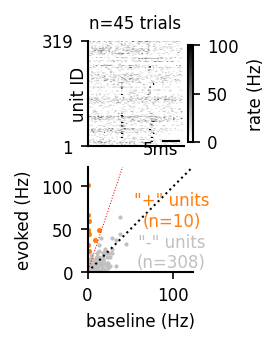

In [15]:
positive_units, fig, AX = analyze_optotagging_responses(session, trials, units,
                                                        pos_color='tab:orange',
                                                        neg_color='silver',
                                                        with_fig=True)
fig.savefig('../figures/visual_coding/SST-session-phototagging.svg')

## Example PV-Cre session

In [16]:
session = cache.get_session_data(721123822)

# units in the visual system
units = session.units[session.units.ecephys_structure_acronym.str.match('VIS')]
# we use the 10ms pulse 
trials = session.optogenetic_stimulation_epochs[\
                (session.optogenetic_stimulation_epochs.stimulus_name=='pulse') & 
                (session.optogenetic_stimulation_epochs.duration > 0.009) &
                (session.optogenetic_stimulation_epochs.duration < 0.02)]

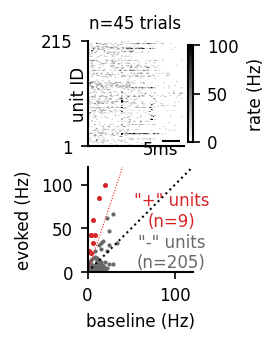

In [17]:
positive_units, fig, AX = analyze_optotagging_responses(session, trials, units,
                                                        pos_color='tab:red',
                                                        neg_color='dimgrey',
                                                        with_fig=True)
fig.savefig('../figures/visual_coding/PV-session-phototagging.svg')

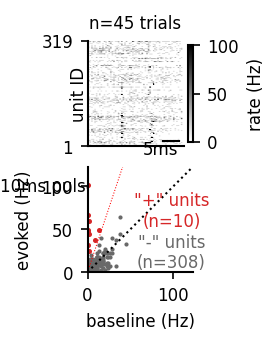

In [20]:
session = cache.get_session_data(756029989)
#session = cache.get_session_data(721123822)

# considering all units in V1
#units = session.units[session.units.ecephys_structure_acronym.str.match('VISp')]
# considering all units in the visual cortex
units = session.units[session.units.ecephys_structure_acronym.str.match('VIS')]

# we use the 10ms pulse 
trials = session.optogenetic_stimulation_epochs[\
                (session.optogenetic_stimulation_epochs.stimulus_name=='pulse') & 
                (session.optogenetic_stimulation_epochs.duration > 0.009) &
                (session.optogenetic_stimulation_epochs.duration < 0.02)]

# final units
positive_units, fig, _ = analyze_optotagging_responses(session, trials, units,
                                                    label='10ms pulse',
                                                    with_fig=True)

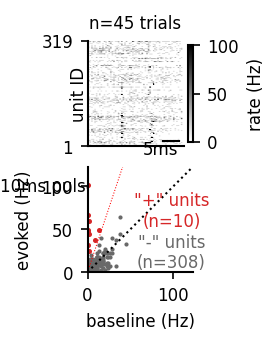

In [21]:
trials = session.optogenetic_stimulation_epochs[\
                (session.optogenetic_stimulation_epochs.stimulus_name=='pulse') & 
                (session.optogenetic_stimulation_epochs.duration > 0.009) &
                (session.optogenetic_stimulation_epochs.duration < 0.02)]

_ = analyze_optotagging_responses(session, trials, units, #spikes_matrix,
                                  label='10ms pulse', with_fig=True)

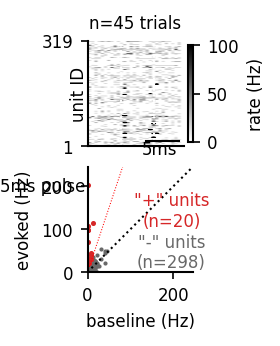

In [22]:
trials = session.optogenetic_stimulation_epochs[\
                (session.optogenetic_stimulation_epochs.stimulus_name=='pulse') & 
                (session.optogenetic_stimulation_epochs.duration > 2e-3) &
                (session.optogenetic_stimulation_epochs.duration < 8e-3)]
_ = analyze_optotagging_responses(session, trials, units, #spikes_matrix,
                                  label='5ms pulse', with_fig=True)

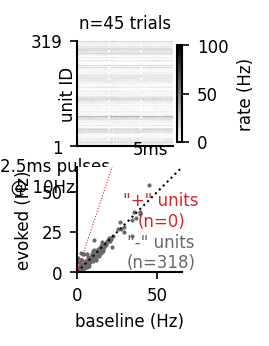

In [23]:
trials = session.optogenetic_stimulation_epochs[\
        (session.optogenetic_stimulation_epochs.stimulus_name=='fast_pulses')]
_ = analyze_optotagging_responses(session, trials, units,
                                  label='2.5ms pulses\n  @ 10Hz', with_fig=True)

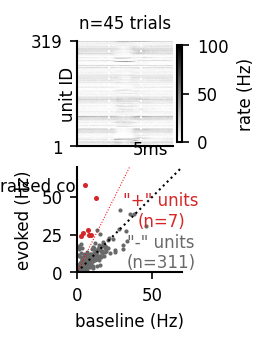

In [24]:
trials = session.optogenetic_stimulation_epochs[\
        (session.optogenetic_stimulation_epochs.stimulus_name=='raised_cosine')]
_ = analyze_optotagging_responses(session, trials, units,
                                  inclusion_evoked_factor=2.,
                                  label='raised cosine', with_fig=True)

## Loop over sessions

In [30]:
Optotagging = {}

Nmin_units =  2

for Sessions, Key in zip([PV_sessions, SST_sessions],
                         ['PV_sessions', 'SST_sessions']):
    
    Optotagging[Key] = []
    Optotagging[Key.replace('sessions', 'positive_units')] = []
    Optotagging[Key.replace('sessions', 'negative_units')] = []
    Optotagging[Key.replace('sessions', 'session_type')] = []

    for iSession in range(len(Sessions)):
        
        print(Key, '---> session #%i' % (iSession+1))
        session = cache.get_session_data(Sessions.index.values[iSession])

        # considering all units in V1
        #units = session.units[session.units.ecephys_structure_acronym.str.match('VISp')]
        # considering all units in the visual cortex
        units = session.units[session.units.ecephys_structure_acronym.str.match('VIS')]

        # we use the 10ms pulse 
        trials = session.optogenetic_stimulation_epochs[\
                        (session.optogenetic_stimulation_epochs.stimulus_name=='pulse') & 
                        (session.optogenetic_stimulation_epochs.duration > 0.009) &
                        (session.optogenetic_stimulation_epochs.duration < 0.02)]

        # final units
        positive_units, fig, _ = analyze_optotagging_responses(session, trials, units,
                                                       label='10ms pulse',
                                                       with_fig=True)
        negative_units = [i for i in units.index if i not in positive_units]
        
        print('%s : #%i (n=%i positive units) \n' % (Key, iSession+1, len(positive_units)))
        fig.suptitle('%s : #%i (n=%i positive units) \n' % (Key, iSession+1, len(positive_units)))
        fig.savefig(os.path.join('..', 'figures', 'visual_coding', 
                    'Optotagging', Key+'-%i.png' % (iSession+1)))
        plt.close(fig)

        if len(positive_units)>=Nmin_units:
            Optotagging[Key].append(Sessions.index.values[iSession])
            Optotagging[Key.replace('sessions', 'positive_units')].append(positive_units)
            Optotagging[Key.replace('sessions', 'negative_units')].append(negative_units)
            Optotagging[Key.replace('sessions', 'session_type')].append(session.session_type)
        
# considering all units in V1
#np.save(os.path.join('..', 'data', 'visual_coding', 'Optotagging-Results-VISp.npy'), Optotagging)
# considering all units in the visual cortex
np.save(os.path.join('..', 'data', 'visual_coding', 'Optotagging-Results.npy'), Optotagging)

PV_sessions ---> session #1
PV_sessions : #1 (n=9 positive units) 

PV_sessions ---> session #2
PV_sessions : #2 (n=1 positive units) 

PV_sessions ---> session #3
PV_sessions : #3 (n=2 positive units) 

PV_sessions ---> session #4
PV_sessions : #4 (n=0 positive units) 

PV_sessions ---> session #5
PV_sessions : #5 (n=27 positive units) 

PV_sessions ---> session #6
PV_sessions : #6 (n=36 positive units) 

PV_sessions ---> session #7
PV_sessions : #7 (n=35 positive units) 

PV_sessions ---> session #8
PV_sessions : #8 (n=37 positive units) 

SST_sessions ---> session #1
SST_sessions : #1 (n=4 positive units) 

SST_sessions ---> session #2
SST_sessions : #2 (n=4 positive units) 

SST_sessions ---> session #3
SST_sessions : #3 (n=10 positive units) 

SST_sessions ---> session #4
SST_sessions : #4 (n=2 positive units) 

SST_sessions ---> session #5
SST_sessions : #5 (n=2 positive units) 

SST_sessions ---> session #6
SST_sessions : #6 (n=3 positive units) 

SST_sessions ---> session #7
SS

In [38]:
Optotagging = np.load(os.path.join('..', 'data', 'visual_coding', 'Optotagging-Results.npy'),
                      allow_pickle=True).item()

for Key in ['PV_sessions', 'SST_sessions']:
    print('')
    print('- N=%i sessions' % len(Optotagging[Key]))
    print(Key, ' ---> %i positive units' % np.sum([len(x) for x in Optotagging[Key.replace('sessions', 'positive_units')]]))
    print('     %.0f +/- %.0f positive units' % (\
        np.mean([len(x) for x in Optotagging[Key.replace('sessions', 'positive_units')]]),
        np.std([len(x) for x in Optotagging[Key.replace('sessions', 'positive_units')]])))
    print(Key, ' ---> %i negative units' % np.sum([len(x) for x in Optotagging[Key.replace('sessions', 'negative_units')]]))
    print('     %.0f +/- %.0f positive units' % (\
        np.mean([len(x) for x in Optotagging[Key.replace('sessions', 'negative_units')]]),
        np.std([len(x) for x in Optotagging[Key.replace('sessions', 'negative_units')]])))



- N=6 sessions
PV_sessions  ---> 146 positive units
     24 +/- 14 positive units
PV_sessions  ---> 1504 negative units
     251 +/- 49 positive units

- N=12 sessions
SST_sessions  ---> 97 positive units
     8 +/- 6 positive units
SST_sessions  ---> 3698 negative units
     308 +/- 108 positive units
